# Modelo Econométrico de la Deuda Externa en función de RIN, TCN e Inflación

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

# 1. Planteamiento del problema


* Pregunta de investigación:

¿Cómo influyen el tipo de cambio nominal, las reservas internacionales netas (RIN) y la inflación en la evolución de la deuda externa del Perú durante el período 2003–2025 con datos trimestrales?

* Hipótesis teórica:



1.   Un aumento del tipo de cambio nominal (depreciación de la moneda) tiende a incrementar la carga de la deuda externa expresada en moneda local.

2.   Un mayor nivel de reservas internacionales debería contribuir a una reducción de la deuda externa, ya que fortalece la capacidad de pago del país.

3. Una mayor inflación puede tener dos efectos:

* Positivo: cuando genera mayor necesidad de financiamiento externo para cubrir déficits, incrementando la deuda externa.

* Negativo: cuando reduce el valor real de las obligaciones en moneda local, disminuyendo la carga relativa de la deuda.




# 2. Selección del modelo econométrico

$$
\ln(\text{Deuda}_t) = \beta_0 + \beta_1 \ln(\text{RIN}_t) + \beta_2 \ln(\text{Inflación}_t) + \beta_3 \ln(\text{TIPO CAMBIO}_t) + u_t
$$

## 3. Recolección de datos (BCRP):




*  PN03367FQ: Deuda Externa
*  PN06481IM: Reservas Internacionales
*  PN01216PM: Tipo de Cambio
*  PN01279PM: Inflacion



# 4. Análisis exploratorio

In [33]:
## A) CARGAR LOS DATOS
df = pd.read_excel('/content/datos.xlsx')
print(df)

   tiempo     deuda           rin  inflacion      tipo
0    T103  1.822944  10184.154723   1.245719  3.478017
1    T203  1.611718  10271.183977   1.206494  3.475483
2    T303  2.200025   9827.972123   0.883552  3.478508
3    T403  1.700115  10102.212727   0.640826  3.471683
4    T104  2.035283  10492.595750   0.800098  3.477900
..    ...       ...           ...        ...       ...
85   T224  0.708736  73282.357817   3.424180  3.775300
86   T324  0.447429  78471.299481   2.929722  3.722200
87   T424  0.707822  81841.171646   2.545320  3.759700
88   T125  0.619679  82090.952732   2.398547  3.691867
89   T225  0.616448  85230.055379   2.289179  3.613133

[90 rows x 5 columns]


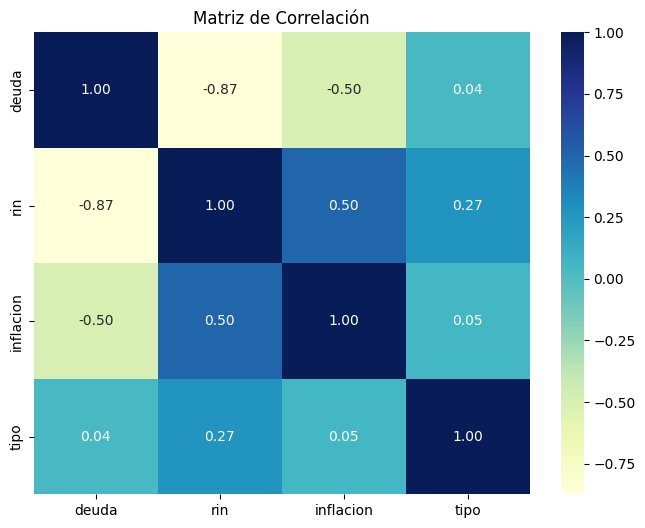

In [34]:
## B) MATRIZ DE CORRELACION
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [35]:
## B) TRANSFORMAR LOS DATOS A LN
df["ln_deuda"] = np.log(df["deuda"])
df["ln_rin"] = np.log(df["rin"])
df["ln_inflacion"] = np.log(df["inflacion"].abs())
df["ln_tipo"] = np.log(df["tipo"])
df = df.drop(columns=["deuda", "rin", "inflacion", "tipo"])
print(df)

   tiempo  ln_deuda     ln_rin  ln_inflacion   ln_tipo
0    T103  0.600453   9.228588      0.219713  1.246462
1    T203  0.477301   9.237098      0.187719  1.245734
2    T303  0.788469   9.192988     -0.123806  1.246604
3    T403  0.530696   9.220510     -0.444998  1.244640
4    T104  0.710635   9.258425     -0.223021  1.246429
..    ...       ...        ...           ...       ...
85   T224 -0.344272  11.202075      1.230862  1.328480
86   T324 -0.804237  11.270488      1.074907  1.314315
87   T424 -0.345563  11.312536      0.934256  1.324339
88   T125 -0.478554  11.315583      0.874863  1.306132
89   T225 -0.483781  11.353109      0.828193  1.284575

[90 rows x 5 columns]


In [36]:
## C) ANALISIS DESCRIPTIVO
print(df.dtypes)
print("------------------------------")
print(df.isnull().sum())
print("------------------------------")
print(df.describe(include='all'))

tiempo           object
ln_deuda        float64
ln_rin          float64
ln_inflacion    float64
ln_tipo         float64
dtype: object
------------------------------
tiempo          0
ln_deuda        0
ln_rin          0
ln_inflacion    0
ln_tipo         0
dtype: int64
------------------------------
       tiempo   ln_deuda     ln_rin  ln_inflacion    ln_tipo
count      90  90.000000  90.000000     90.000000  90.000000
unique     90        NaN        NaN           NaN        NaN
top      T103        NaN        NaN           NaN        NaN
freq        1        NaN        NaN           NaN        NaN
mean      NaN  -0.403511  10.661258      0.956928   1.175118
std       NaN   0.548374   0.666257      0.529543   0.114551
min       NaN  -1.383746   9.192988     -0.444998   0.945306
25%       NaN  -0.816747  10.358943      0.602910   1.071802
50%       NaN  -0.569812  11.012718      1.032179   1.186770
75%       NaN  -0.106363  11.122473      1.323311   1.246454
max       NaN   0.788469  11.3

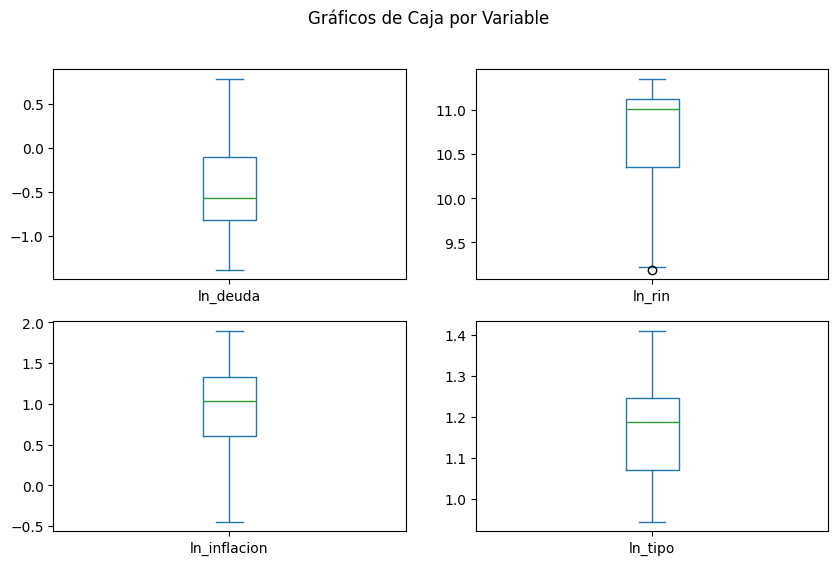

In [37]:
## D) GRAFICO DE CAJA
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,6), sharex=False, sharey=False)
plt.suptitle("Gráficos de Caja por Variable")
plt.show()

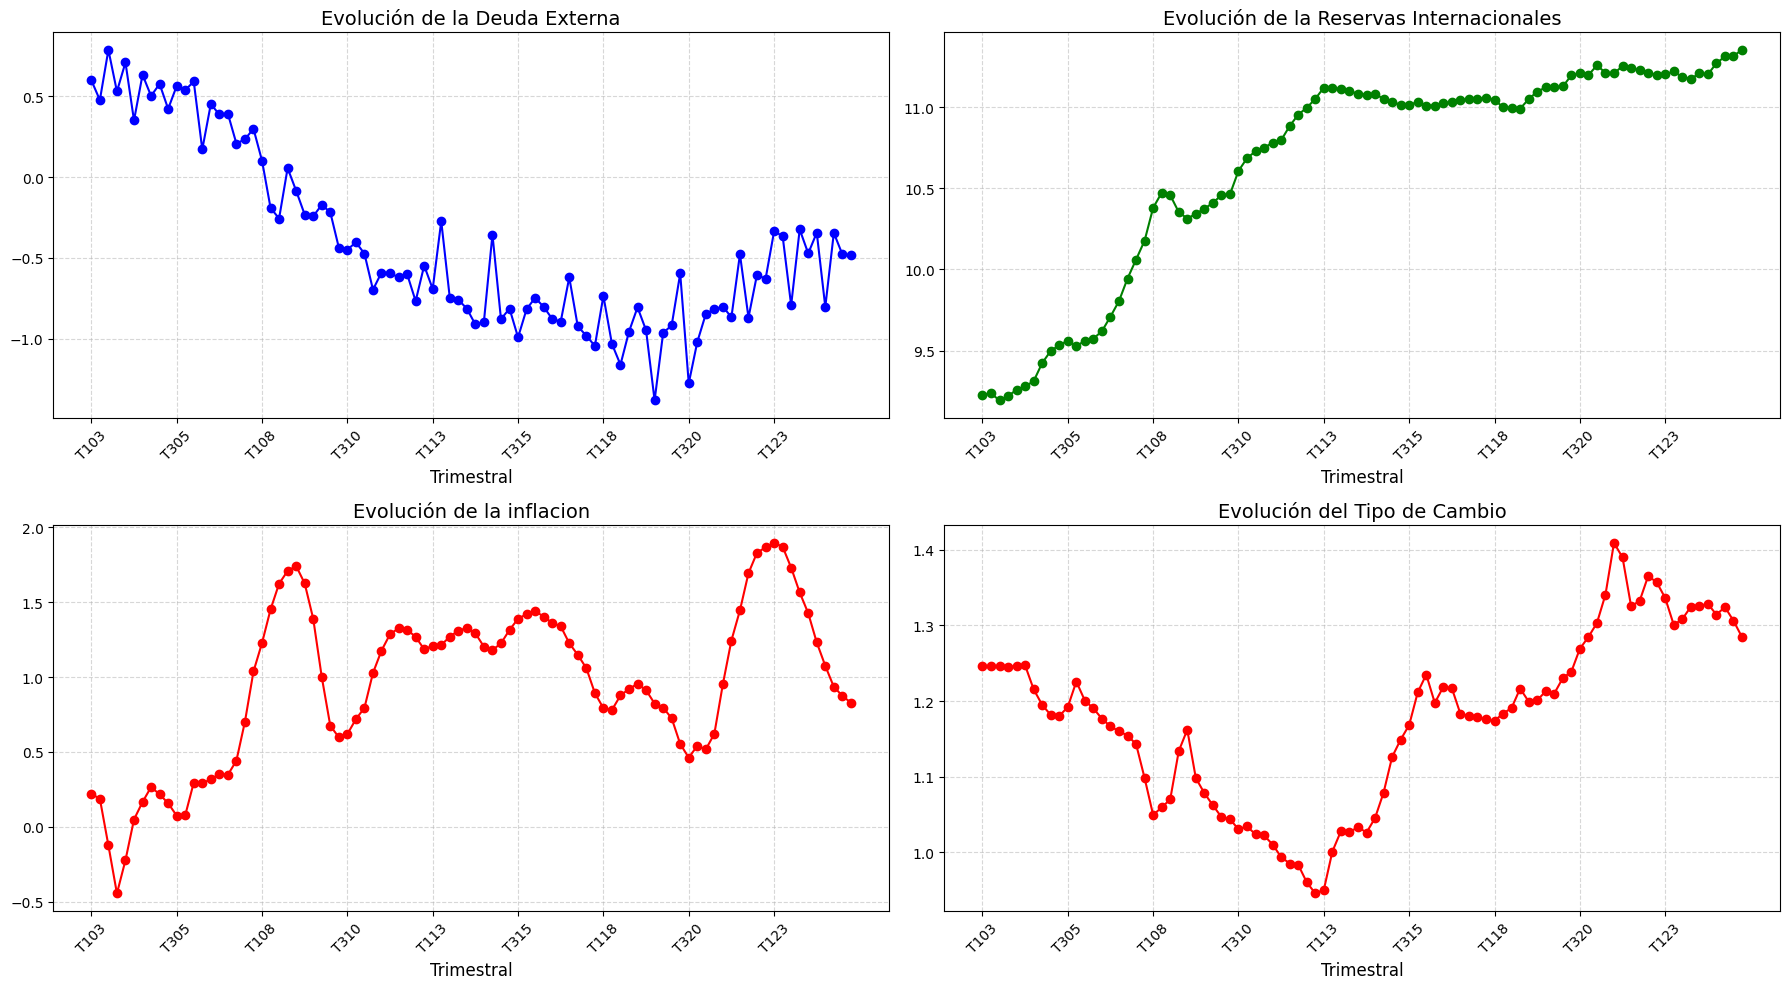

In [38]:
## E) ANALISIS DE LA SERIES EN EL TIEMPO
# Crear subplots (1 fila, 3 columnas)
fig, axes = plt.subplots(2, 2, figsize=(18,10))

# Gráfico 1:
axes[0,0].plot(df["tiempo"], df["ln_deuda"], marker="o", linestyle="-", color="blue")
axes[0,0].set_title("Evolución de la Deuda Externa", fontsize=14)
axes[0,0].set_xlabel("Trimestral", fontsize=12)
axes[0,0].set_ylabel("", fontsize=12)
axes[0,0].grid(True, linestyle="--", alpha=0.5)
axes[0,0].set_xticks(df["tiempo"][::10])
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2:
axes[0,1].plot(df["tiempo"], df["ln_rin"], marker="o", linestyle="-", color="green")
axes[0,1].set_title("Evolución de la Reservas Internacionales", fontsize=14)
axes[0,1].set_xlabel("Trimestral", fontsize=12)
axes[0,1].set_ylabel("", fontsize=12)
axes[0,1].grid(True, linestyle="--", alpha=0.5)
axes[0,1].set_xticks(df["tiempo"][::10])
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3:
axes[1,0].plot(df["tiempo"], df["ln_inflacion"], marker="o", linestyle="-", color="red")
axes[1,0].set_title("Evolución de la inflacion", fontsize=14)
axes[1,0].set_xlabel("Trimestral", fontsize=12)
axes[1,0].set_ylabel("", fontsize=12)
axes[1,0].grid(True, linestyle="--", alpha=0.5)
axes[1,0].set_xticks(df["tiempo"][::10])
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4:
axes[1,1].plot(df["tiempo"], df["ln_tipo"], marker="o", linestyle="-", color="red")
axes[1,1].set_title("Evolución del Tipo de Cambio", fontsize=14)
axes[1,1].set_xlabel("Trimestral", fontsize=12)
axes[1,1].set_ylabel("", fontsize=12)
axes[1,1].grid(True, linestyle="--", alpha=0.5)
axes[1,1].set_xticks(df["tiempo"][::10])
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Estimación del modelo

In [39]:
# Definir variables independientes y dependiente
X = df[["ln_tipo",'ln_inflacion',"ln_rin"]]
y = df["ln_deuda"]

# Agregar constante para el intercepto
X = sm.add_constant(X)

# Crear modelo y ajustar
modelo = sm.OLS(y, X).fit()

# Resumen del modelo
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_deuda   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     145.3
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           1.43e-33
Time:                        14:00:11   Log-Likelihood:                 8.0235
No. Observations:                  90   AIC:                            -8.047
Df Residuals:                      86   BIC:                             1.952
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.9415      0.525     15.139   

## 6. Diagnósticos econométricos

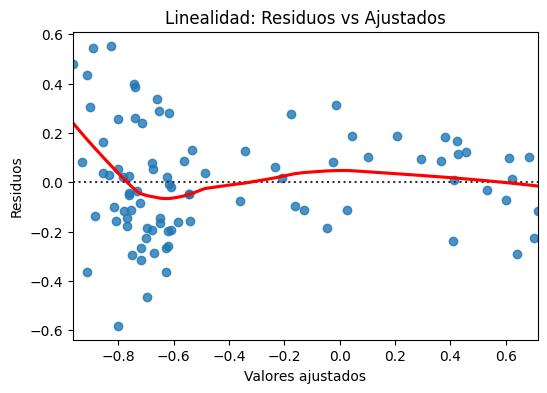

In [40]:
# 1. Linealidad (gráfico residuos vs valores ajustados)
plt.figure(figsize=(6,4))
sns.residplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True, line_kws={"color":"red"})
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()


Test Shapiro-Wilk:
Estadístico: 0.9897919361975325  | p-value: 0.7157803362307223
✅ Normalidad (no se rechaza H0)


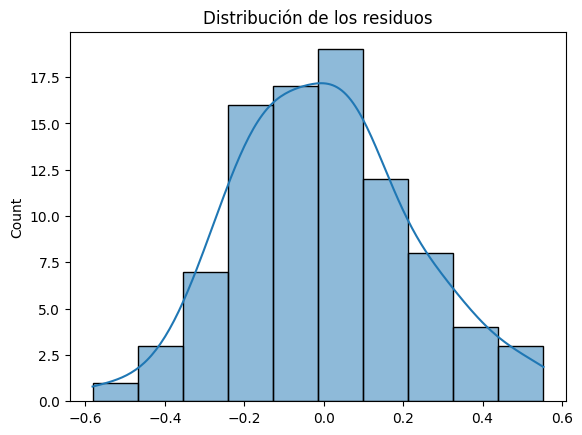

In [41]:
# 2. Normalidad de errores
# Shapiro-Wilk
stat_shapiro, p_shapiro = shapiro(modelo.resid)
print("\nTest Shapiro-Wilk:")
print("Estadístico:", stat_shapiro, " | p-value:", p_shapiro)
if p_shapiro > 0.05:
    print("✅ Normalidad (no se rechaza H0)")
else:
    print("❌ No normalidad (se rechaza H0)")

sns.histplot(modelo.resid, kde=True)
plt.title("Distribución de los residuos")
plt.show()

In [42]:
# 3. Homocedasticidad (Breusch-Pagan): Los errores tienen la misma varianza en todas las observaciones
bp_test = het_breuschpagan(modelo.resid, modelo.model.exog)
labels = ["LM Statistic","LM-Test p-value","F-Statistic","F-Test p-value"]
results = dict(zip(labels, bp_test))

print("\nTest de Breusch-Pagan (Homocedasticidad):")
print(results)

if results["LM-Test p-value"] > 0.05:
    print("✅ Se cumple homocedasticidad (no se rechaza H0).")
else:
    print("❌ No se cumple homocedasticidad (se rechaza H0).")


Test de Breusch-Pagan (Homocedasticidad):
{'LM Statistic': np.float64(12.229153333366282), 'LM-Test p-value': np.float64(0.006638016578212664), 'F-Statistic': np.float64(4.507718216388826), 'F-Test p-value': np.float64(0.005505270546293193)}
❌ No se cumple homocedasticidad (se rechaza H0).



Prueba Durbin-Watson:
Estadístico DW: 1.1939
Posible autocorrelación positiva de los residuos.


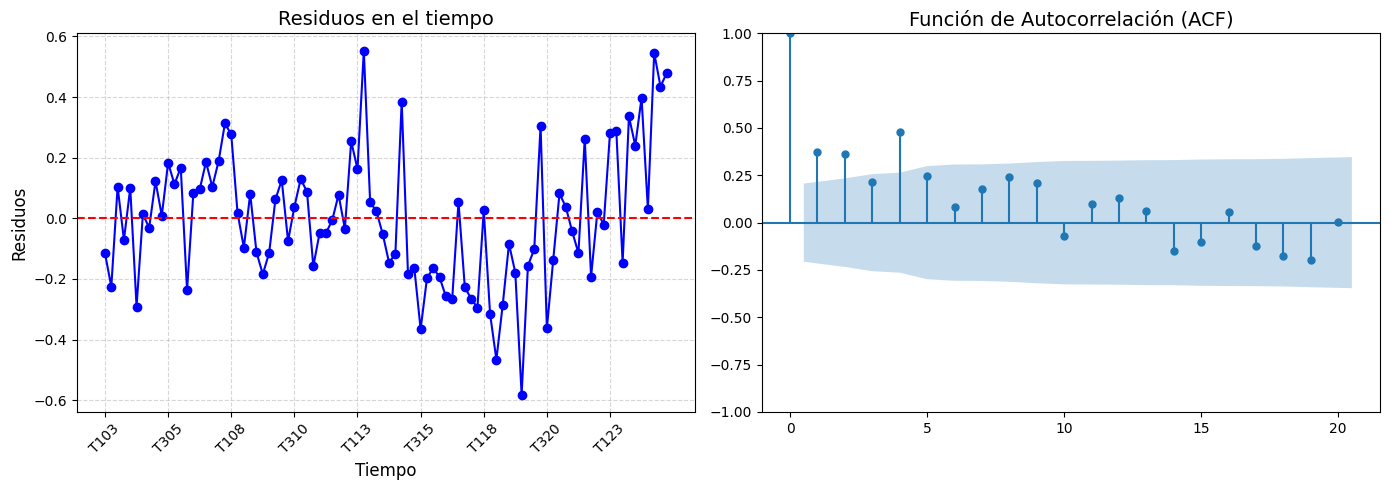

In [43]:
# 4. Durbin-Watson
dw_stat = durbin_watson(modelo.resid)

print("\nPrueba Durbin-Watson:")
print("Estadístico DW:", round(dw_stat, 4))

# Interpretación
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación.")

# Crear figura con 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===============================
# Gráfico 1: Residuos en el tiempo
axes[0].plot(df["tiempo"], modelo.resid, marker="o", linestyle="-", color="blue")
axes[0].axhline(y=0, color="red", linestyle="--")
axes[0].set_title("Residuos en el tiempo", fontsize=14)
axes[0].set_xlabel("Tiempo", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)


axes[0].set_xticks(df["tiempo"][::10])
axes[0].tick_params(axis='x', rotation=45)

# ===============================
# Gráfico 2: Autocorrelación (ACF)
sm.graphics.tsa.plot_acf(modelo.resid, lags=20, ax=axes[1])
axes[1].set_title("Función de Autocorrelación (ACF)", fontsize=14)

plt.tight_layout()
plt.show()


# 7. Interpretación económica

* Bondad de ajuste (R² = 0.835):
El modelo explica aproximadamente el 83.5% de la variabilidad de la deuda externa, lo cual indica un ajuste bastante sólido.

* El estadístico F (145.3) es altamente significativo (p < 0.01), lo que confirma que el modelo en su conjunto es estadísticamente válido.

* Constante (β₀ = 7.94):
Representa el nivel base de la deuda externa en logaritmos. Si bien no tiene una interpretación económica directa, cumple un rol de ajuste en el modelo.

* Tipo de cambio nominal (β₁ = 0.472, p = 0.030):
El coeficiente positivo y significativo donde indica que un aumento del 1% en el tipo de cambio nominal (depreciación del sol frente al dólar) está asociado con un incremento del 0.472% en la deuda externa. (Tipo de cambio nominal↑⇒Deuda externa↑)

* Inflación (β₂ = 0.1808, p = 0.007): El coeficiente positivo y significativo muestra que un aumento del 1% en la inflación incrementa en 0.18% la deuda externa. (Inflacion↑ = Dependencia financiamiento externo↑)

* Reservas internacionales netas – RIN (β₃ = -0.851, p = 0.000): El coeficiente negativo y altamente significativo sugiere que un aumento del 1% en las RIN está asociado con una reducción del 0.85% en la deuda externa.(RIN ↑ = Dependencia financiamiento externo↓)

# 8. Conclusiones


* El tipo de cambio nominal y la inflación afectan positivamente la deuda externa, es decir, la incrementan.

* Las reservas internacionales netas afectan negativamente la deuda externa, ayudando a reducirla.

* En conjunto, el modelo confirma la importancia de la estabilidad cambiaria, el control de la inflación y la acumulación de reservas para mantener sostenible el nivel de endeudamiento externo en el Perú entre 2003 y 2025.